## 1- Weekly news detailed report workflow

- It must take the topics of interest of the user

- User's background knowledge

_______________

## 2- Weekly news high level summarizer

- It must take the topics of interest of the user (too)

- User's background knowledge

______________

## 3- Weekly news QA Chatbot 

- User's background knowledge

In [1]:
from utils.chatbot_graph import app, thread

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
app.invoke({"question":"current relations between Venezuela and Spain"}, thread)["generation"]

"Venezuela and Spain's relations are currently strained. Tensions have risen due to Venezuela's arrest of an Argentine officer, which has also affected Spain because of previous similar incidents involving Spanish citizens. This situation is further complicated by Spain's recognition of an opposition candidate in Venezuela, which the Venezuelan government sees as interference. Historically, their relationship has been complex, influenced by differing political ideologies."

In [4]:
from langgraph.errors import GraphRecursionError

In [6]:
try:
    print(app.invoke({"question":"current relations between Venezuela and Spain"}, thread)["generation"])
except GraphRecursionError:
    print("Recursion Error") 

Venezuela and Spain's relations are currently strained. Tensions have risen due to Venezuela's arrest of an Argentine officer, which has also affected Spain because of previous similar incidents involving Spanish citizens. This situation is compounded by Spain's recognition of an opposition candidate in Venezuela, which the Venezuelan government saw as interference. Historically, their relationship has been complex, influenced by differing political ideologies.


## --- Implementing the sample SST-TTS with the chatbot inside

Speech to text setting (`we'll start with a duration=5 secs before proceeding with the transcription`)

In [1]:
import sounddevice as sd

def record_audio(duration=5, sample_rate=44100):
    print("Recording...")
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=2, dtype='int16')
    sd.wait()
    return recording

In [2]:
from pydub import AudioSegment
import numpy as np
import os

def save_as_mp3(audio_data, sample_rate=44100, file_name='output.mp3', folder='audio'):
    if not os.path.exists(folder):
        os.makedirs(folder)
    full_path = os.path.join(folder, file_name)
    audio_segment = AudioSegment(
        data=np.array(audio_data).tobytes(),
        sample_width=2,
        frame_rate=sample_rate,
        channels=2
    )
    audio_segment.export(full_path, format='mp3')
    return full_path

In [3]:
from openai import OpenAI

def transcribe_audio(file_path):
    client = OpenAI()
    with open(file_path, "rb") as audio_file:
        transcription = client.audio.transcriptions.create(
            model="whisper-1",
            file=audio_file,
            language='en'
        )
    print(f'Transcription: {transcription.text}')

In [4]:
import keyboard

: 

In [36]:
#testing the STT

sample_rate = 44100  # Sample rate in Hz
duration = 5  # Duration of recording in seconds
try:
    while True:
        if keyboard.is_pressed('esc'):  # Check if ESC key is pressed to exit
            print("Exiting...")
            break
        audio_data = record_audio(duration, sample_rate)
        file_path = save_as_mp3(audio_data, sample_rate)
        transcribe_audio(file_path)
except KeyboardInterrupt:
    print("Program terminated.")

Recording...
Transcription: Hey, what's up? How are you doing?
Recording...
Transcription: I want to know about you.
Recording...
Transcription: I want to know the last news about Venezuela.
Recording...
Transcription: . .
Recording...
Transcription: Wow
Recording...
Transcription: Cool.
Recording...
Transcription: Very, very, very cool, actually.
Recording...
Transcription: Thank you.
Recording...
Transcription: Bye.
Recording...


: 

___________

This method processes chunks of text and plays them using an in-memory temporary file, allowing speech to begin before the entire text is processed by the TTS model

### Chunking Technique Explanation

The **chunking technique** in your code involves breaking the input text into smaller pieces (or chunks), which are then processed separately to generate speech. Instead of sending the entire text at once for processing by the AI, the text is split into smaller parts, each of which is sent to the text-to-speech system.

The process is as follows:
1. **Text Splitting**: The text is divided into chunks of a certain size (number of words, in this case).
2. **Speech Generation**: Each chunk is sent individually to the text-to-speech API to generate speech.
3. **Playback**: After generating the speech for a chunk, it's played before processing the next chunk.

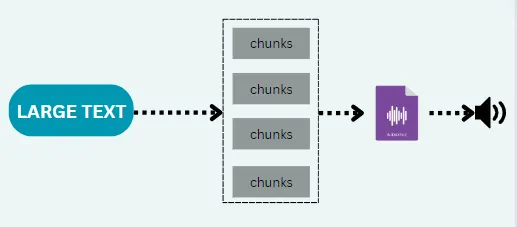

In [1]:
text = """


The sun dipped low over the sprawling forests of Eldara, casting golden light across the ancient treetops. For centuries, the Kingdom of Eldara had been a place of peace, shielded by its natural barriers and the wisdom of its rulers. Yet, deep within the heart of the kingdom, whispers of an ancient prophecy were beginning to stir.

In the quiet village of Ravendale, nestled at the edge of the Crystal River, a young blacksmith named Kael worked tirelessly at his forge. Sparks flew as his hammer struck glowing steel, shaping it into a blade that seemed to hum with hidden power. Kael had always been drawn to the forge, not just for its warmth, but for the way it connected him to his late father, a master craftsman who had once served the king.
"""

____________

#### 3.1 Testing the `async` TTS streaming

In [18]:
from openai import OpenAI
from io import BytesIO
from pydub import AudioSegment
from pydub.playback import play
from time import sleep

client = OpenAI()

# def speak_chunk_openai(chunk):
#     # Generate speech from OpenAI TTS
#     response = client.audio.speech.create(
#         model="tts-1",
#         voice="nova",
#         input=chunk
#     )
    
#     # Access the binary audio data
#     audio_data = response.content  # Correct way to access the content
    
#     # Convert the binary audio data to AudioSegment
#     audio = AudioSegment.from_mp3(BytesIO(audio_data))  # Correct format handling
#     play(audio)

#------------------------------------------------------------
import time

def speak_chunk_openai(chunk):
    start_time = time.time()
    response = client.audio.speech.create(
        model="tts-1",
        voice="nova",
        input=chunk
    )
    audio_data = response.content
    audio = AudioSegment.from_mp3(BytesIO(audio_data))
    play(audio)
    end_time = time.time()
    print(f"Chunk processed in {end_time - start_time:.2f} seconds.")


def chunked_speak_openai(text, chunk_size=50):
    words = text.split()
    chunks = [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)] 
    for chunk in chunks:
        speak_chunk_openai(chunk)



- Small chunks (e.g., 10–20 words) mean the AI system generates speech more quickly for each chunk. However, the overhead of multiple API requests can add up, potentially increasing the overall response time.

- Large chunks (e.g., 50–100 words) reduce the number of API calls but might take longer to process each request. The response time per chunk will be longer because the AI has more text to handle, but you have fewer requests overall.

In [19]:
chunked_speak_openai(text, chunk_size=10)

Chunk processed in 6.76 seconds.
Chunk processed in 5.88 seconds.
Chunk processed in 5.45 seconds.
Chunk processed in 6.23 seconds.
Chunk processed in 5.74 seconds.
Chunk processed in 5.85 seconds.
Chunk processed in 5.25 seconds.
Chunk processed in 6.47 seconds.
Chunk processed in 5.65 seconds.
Chunk processed in 4.58 seconds.
Chunk processed in 4.60 seconds.
Chunk processed in 4.90 seconds.
Chunk processed in 5.69 seconds.
Chunk processed in 2.72 seconds.


____________

#### 3.2 Using an `async` approach instead

- We divide the words into small chunks so we get the corresponding audio for each small piece

- But with using `async` approach, we can convert to speech all these pieces at the same time without doing once at a time

In [1]:
import openai
import asyncio
from io import BytesIO
from pydub import AudioSegment
from pydub.playback import play
import time
from openai import OpenAI
client = OpenAI()

# Set up OpenAI API key

async def speak_chunk_openai(chunk):
    """Asynchronous function to get speech from OpenAI and play the audio."""
    start_time = time.time()

    # Using OpenAI's Python client to generate audio
    response = client.audio.speech.create(
        model="tts-1",  # Ensure you're using the correct model
        voice="nova",  # Specify the voice
        input=chunk  # Text chunk to convert to speech
    )

    # Extract audio content from the response
    audio_data = response.content  # Correct way to access the content
    audio = AudioSegment.from_mp3(BytesIO(audio_data))  # Convert binary to AudioSegment
    play(audio)  # Play the audio

    end_time = time.time()
    print(f"Chunk processed in {end_time - start_time:.2f} seconds.")

async def chunked_speak_openai(text, chunk_size=50):
    """Asynchronous function to process text in chunks and speak."""
    words = text.split()
    chunks = [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]

    # Run the tasks concurrently
    tasks = [speak_chunk_openai(chunk) for chunk in chunks]
    await asyncio.gather(*tasks)  # Wait for all chunks to be processed concurrently



In [ ]:
# Usage example (run this directly in a cell in Jupyter)
text = "This is an example sentence to demonstrate how chunked speech synthesis works with OpenAI's API. This is just a test."
await chunked_speak_openai(text, chunk_size=10)  # Use await instead of asyncio.run()
  # Use await instead of asyncio.run()


Chunk processed in 6.20 seconds.
Chunk processed in 6.20 seconds.


: 

In [9]:
text = """


The sun dipped low over the sprawling forests of Eldara, casting golden light across the ancient treetops. For centuries, the Kingdom of Eldara had been a place of peace, shielded by its natural barriers and the wisdom of its rulers. Yet, deep within the heart of the kingdom, whispers of an ancient prophecy were beginning to stir.

In the quiet village of Ravendale, nestled at the edge of the Crystal River, a young blacksmith named Kael worked tirelessly at his forge. Sparks flew as his hammer struck glowing steel, shaping it into a blade that seemed to hum with hidden power. Kael had always been drawn to the forge, not just for its warmth, but for the way it connected him to his late father, a master craftsman who had once served the king.
"""

In [10]:
# Usage example (run this directly in a cell in Jupyter)
# text = "This is an example sentence to demonstrate how chunked speech synthesis works with OpenAI's API. This is just a test."
await chunked_speak_openai(text, chunk_size=80)  # Use await instead of asyncio.run()
  # Use await instead of asyncio.run()


Chunk processed in 34.07 seconds.
Chunk processed in 21.74 seconds.


_________

#### 3.2.1 Effective Audio Streaming over WebSocket Using Asyncio and Threading

- Threading for background audio processing

- asyncio for non-blocking WebSocket management

This guarantees that partial transcription and live audio streams are handled effectively.

In [ ]:
from langchain.tools import TavilySearchResults
import tavily_client  # Assuming Tavily API is installed and set up

# Use LangChain's TavilySearchResults with 'k' to control results for speed
def search_with_langchain(query, k):
    # Initialize the LangChain TavilySearchResults tool with 'k'
    web_search_tool = TavilySearchResults(k=k)
    results = web_search_tool.search(query)
    return results

# Use Tavily API client directly with 'max_results' to control speed
def search_with_tavily_api(query, max_results):
    result = tavily_client.search(
        query,
        max_results=max_results,  # Set the number of results
        include_raw_content=True,
        topic="general"
    )
    return result

# Test the functions with query
query = "Artificial Intelligence"

# Test with LangChain's TavilySearchResults (using 'k')
print("LangChain Search Results (k=3):")
langchain_results = search_with_langchain(query, k=3)
print(langchain_results)

# Test with Tavily API Client (using 'max_results')
print("\nTavily API Search Results (max_results=3):")
tavily_api_results = search_with_tavily_api(query, max_results=3)
print(tavily_api_results)
